# <center> Guia 5 </center>
Alumnes: Borrell Trinidad, Brusco Agustín

Docentes: Rodriguez Imazio Paola, Amette Estrada Julian

## Imports Generales
Ejecutar la siguiente celda para poder correr el código del Notebook.

In [1]:
import sys
import os
# Colab Set-Up
if ("google.colab" in sys.modules) and (os.getcwd() == '/content'):
    print(
        "Ejecutando en Google Colab\n"
        "Para correr el notebook se necesita clonar un repositorio con funciones "
        "auxiliares e instalar librerías."
    )
    if input(
        "¿Desea clonar el repositorio e instalar los paquetes necesarios?"
        "[y/n]:"
    ).lower() == "y":
        os.system("git clone https://github.com/agustinbrusco/Sistemas_Complejos.git")
        print(
            "Se clonó https://github.com/agustinbrusco/Sistemas_Complejos.git."
        )
        os.chdir("Sistemas_Complejos/guias/")
        %pip install findiff
        %pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()

# Imports Generales
from typing import Callable
import numpy as np
from numpy.typing import ArrayLike
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

**Ejercicio 1: Modelo de presa predador Lotka-Volterra**

---



El modelo de Lotka-Volterra describe la dinámica de interacción de dos poblaciones, y esta dado por

$$ u_t =   au - buv + D_1 u_{xx}, $$
$$ v_t = - cv + duv + D_2 v_{xx}. $$

En estas ecuaciones $u(x,t)$ es la densidad de presas, $v(x,t)$ la de predadores, $a$ la tasa de nacimiento de presas, $c$ la tasa de muerte de predadores, $b$ y $d$ son los acoplamientos entre especies, y $D_1$ y $D_2$ sus difusividades.


**a**) Resolvé numéricamente el sistema considerando condiciones de contorno periódicas en el dominio unidimensional $x \in [0,2\pi)$, utilizando un método a elección. Elegí todos los parámetros y definí las condiciones iniciales para $u$ y para $v$. Explicá detalladamente la elección del método, de los parámetros y de las condiciones iniciales. Describí la dinámica del sistema en término de las soluciones obtenidas.

**b**) Utilizando tu modelo numérico mostrá el efecto que tienen los coeficientes de difusión en el modelo. *Ayuda: probá distintos valores de* $D_1$ y $D_2$

In [2]:
def evol(u: ArrayLike, v: ArrayLike, k: ArrayLike, D1: float, D2:float,a: float, b: float, c: float, d: float, dt: float):
    """Evoluciona en el tiempo la PDE usando el método pseudoespectral y \
Runge-Kutta de segundo orden.
    """
    u_hat = np.fft.rfft(u)  # Transformamos al espacio de Fourier
    u_hat_inicial = u_hat  # Guardamos el estado inicial
    v_hat = np.fft.rfft(v)
    v_hat_inicial = v_hat

    for ord in [2,1]:  # Bucle para el Runge-Kutta
        D = dt/ord
        u_v_hat = compute_interaction(u_hat, v_hat)

        u_hat = u_hat_inicial + D*(a*u_hat - b*u_v_hat - D1*(k**2)*u_hat) # Integramos en el tiempo
        u_hat[(u.size//3):] = 0  # Dealiasing (eliminemos modos espúreos!)

        v_hat = v_hat_inicial + D*(-c*v_hat + d*u_v_hat - D2*(k**2)*v_hat) # Integramos en el tiempo
        v_hat[(v.size//3):] = 0  # Dealiasing (eliminemos modos espúreos!)

    u_nuevo = np.fft.irfft(u_hat)  # Vuelva del espacio de Fourier
    v_nuevo = np.fft.irfft(v_hat)  # Vuelva del espacio de Fourier

    return u_nuevo, v_nuevo

def compute_interaction(u_hat, v_hat):
    """Calcula u*v usando el método pseudoespectral y devuelve el resultado \
en el espacio Fourier.
    """
    u = np.fft.irfft(u_hat)
    v = np.fft.irfft(v_hat)
    u_v_hat = np.fft.rfft(u * v)
    return u_v_hat

In [3]:
def lotka_volterra_pseudoespectral(
    u0: Callable[[ArrayLike], ArrayLike],
    v0: Callable[[ArrayLike], ArrayLike],
    lv_params: tuple[float, float, float, float, float, float],
    tf: float = 5,
    dt: float = 5e-5,
    nx: int = 128,
) -> tuple[ArrayLike, ArrayLike, ArrayLike]:
    # Defino mis puntos en el espacio real y los modos para el espacio de Fourier
    L = 2*np.pi

    x_vals = np.linspace(0, L, nx, endpoint=False)  # Coordenada espacial en [0,2*pi)
    t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
    nt = t_vals.size
    # Números de onda ordenados como en la FFT
    k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

    # Grilla para plot
    u = np.empty([nx, nt])  # Array con la velocidad
    u[:, 0] = u0(x_vals)  # Condiciones iniciales

    v = np.empty([nx, nt])  # Array con la velocidad
    v[:, 0] = v0(x_vals)  # Condiciones iniciales

    # Aplico el método de Euler para la integración temporal
    for n in tqdm(range(nt - 1), desc="Pasos de Pseudo-Espectral"):
        u[:, n+1], v[:, n+1]= evol(u[:, n], v[:, n], k_vals, *lv_params, dt = dt)
    return x_vals, t_vals, u, v

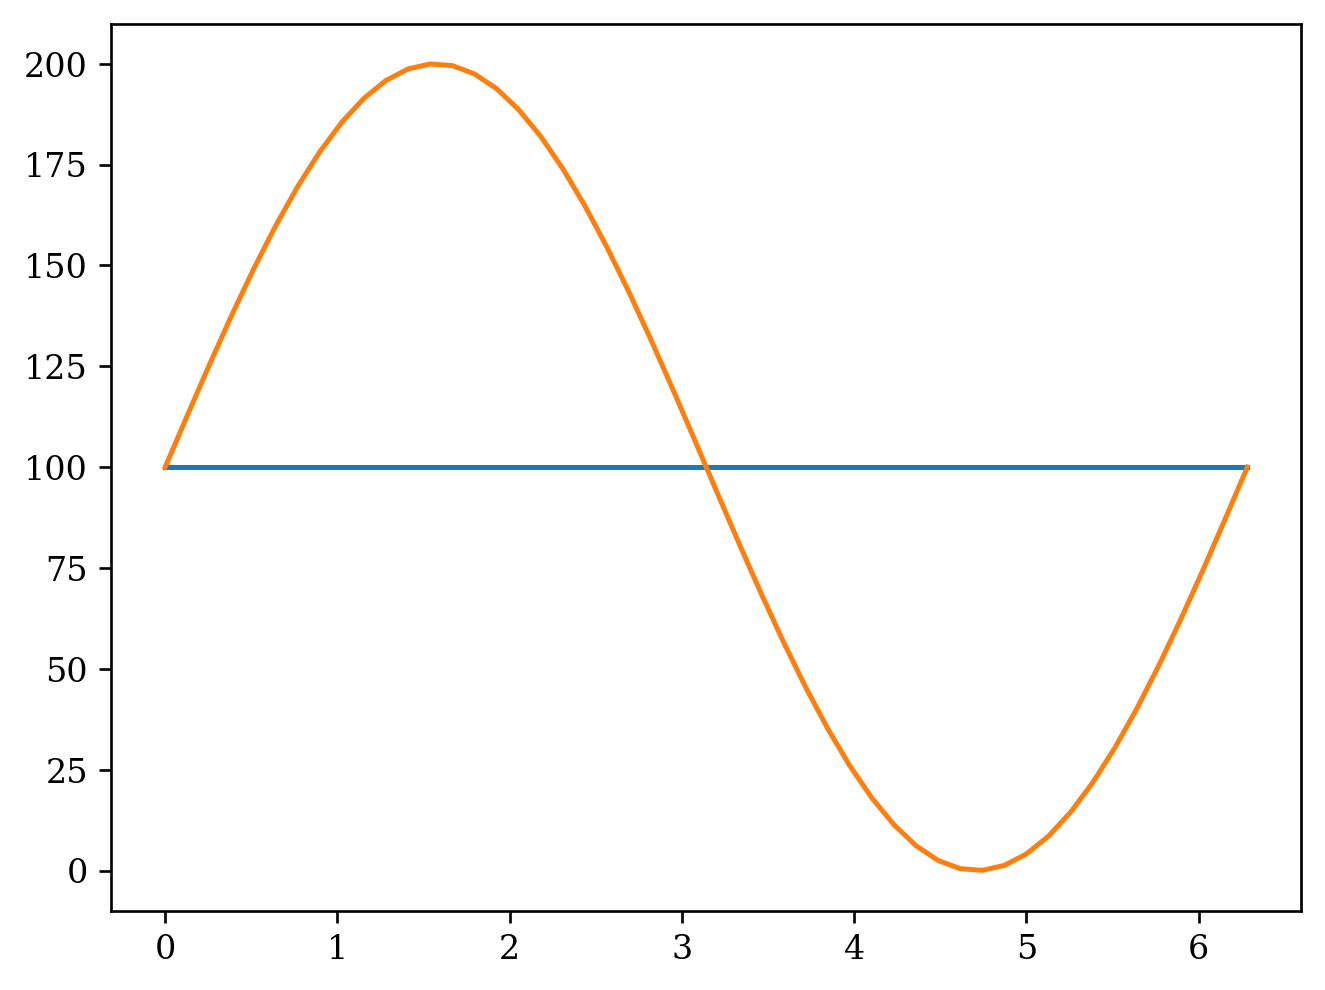

In [4]:
def u0(x):
    # return 5000*gaussian(x, np.pi, np.pi/3)
    a = 100
    # return a*np.sin(x-np.pi) + a
    return np.full_like(x, a)

def v0(x):
    a = 100
    return a*np.sin(x) + a


plt.close("all")
%matplotlib inline
x_vals = np.linspace(0, 2*np.pi)
plt.plot(x_vals, u0(x_vals))
plt.plot(x_vals, v0(x_vals))

In [5]:
x_vals, t_vals, u, v = lotka_volterra_pseudoespectral(
    u0=u0,
    v0=v0,
    lv_params=[
        0.005,  # D1
        0.001,  # D2
        1.5,  # a
        0.02,  # b
        4,  # c
        0.02,  # d
    ],
    tf = 10,
    dt = 5e-3,
    nx = 512,
)

Pasos de Pseudo-Espectral:   0%|          | 0/2000 [00:00<?, ?it/s]

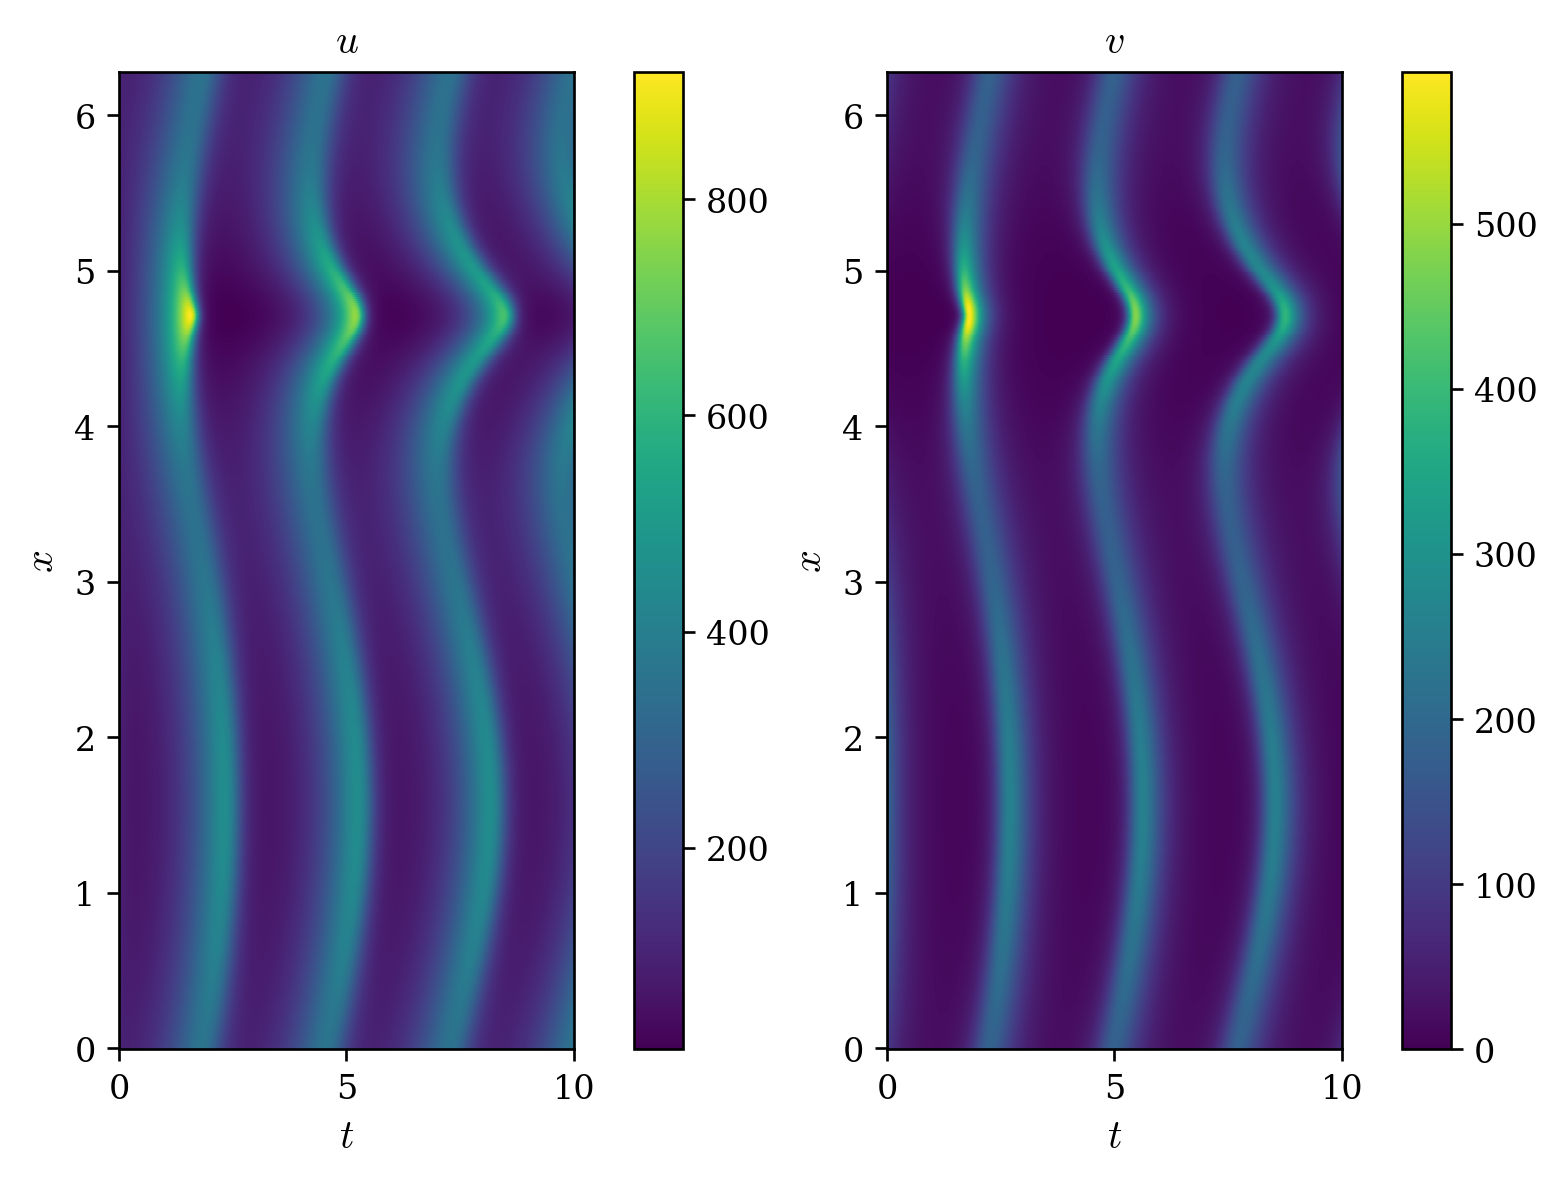

In [6]:
plt.close("all")
%matplotlib inline
fig, axs = plt.subplots(1, 2, constrained_layout=True)
xx_vals, tt_vals = np.meshgrid(x_vals, t_vals, indexing='ij')
for ax, var, var_name, color in zip(axs, [u,v], 'uv', ['viridis', 'viridis']):
    colormap = ax.pcolormesh(tt_vals, xx_vals, var, cmap=color, alpha=1)
    ax.set_xlabel("$t$")
    ax.set_ylabel("$x$")
    ax.set_title(f'${var_name}$')
    plt.colorbar(colormap, ax=ax)
plt.show()

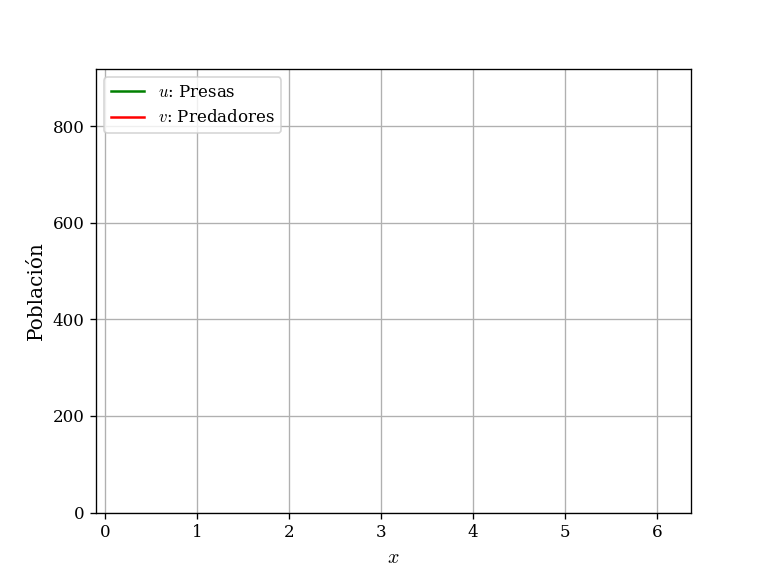

In [7]:
plt.close("all")
%matplotlib widget
fig, ax = plt.subplots()
ax.set_xlabel('$x$')
ax.set_ylabel('Población')
ax.set_xlim(min(x_vals)-0.1,max(x_vals)+0.1)
ax.set_ylim(np.min(np.array([u,v]))-0.1, np.max(np.array([u,v]))+0.1)
ax.grid("True")

linea1, = ax.plot([],[],'-', color = "g", label="$u$: Presas")
linea2, = ax.plot([],[],'-', color = "r", label="$v$: Predadores")
ax.legend(loc="upper left", bbox_to_anchor=(0, 1))

duracion_animacion = 10  # s
frames_per_sec = 30  # s^-1
anim_step = t_vals.size//(frames_per_sec*duracion_animacion)
def graficar(i): #En esta función defino los parámetros para la animación
    linea1.set_data(x_vals, u[:, i*anim_step])
    linea2.set_data(x_vals, v[:, i*anim_step])
    ax.set_title(f"i = {i}, t = {t_vals[i*anim_step]:.2f} / {t_vals[-1]:.0f}")
    return (linea1, linea2)

anim = animation.FuncAnimation(fig, graficar,
                               frames=(frames_per_sec*duracion_animacion),
                               interval=1000//frames_per_sec, blit=True,)
# anim.save("animation.mp4", fps=24)
anim


**Ejercicio 2: Modelo para la propagación del fuego, ecuación de Kuramoto-Sivashinsky**

---




La ecuación de Kuramoto-Sivashinsky viene dada por

$$ u_t = -u_{xx} -u_{xxxx} - (u_x)^2/2 $$

Derivando respecto a x y tomando $v = u_x$ se tiene

$$ v_t = -v_{xx} -v_{xxxx} - vv_x, $$

de donde puede verse que el término $v_{xx}$ representa la reacción, que $v_{xxxx}$ es el término de disipación y $vv_x$ es el término advectivo.


**a**) Qué simetrías tiene esta ecuación? Basado en esto, y dado un dominio de longitud L y cdc periódicas elegí una base de Fourier y escribí una proyección de Galerkin de esta ecuación, hasta llegar a la expresión explícita para la evolución temporal del sistema.

**b**) Escribi explícitamente los primeros cuatro modos y estudiá la primera bifrucación del sistema (a dos modos). A partir de esto, que esperás que pase al agregar mas modos?

**c**) Integrá la ecuación numéricamente con condiciones de contorno periódicas, utilizando un método numérico a elección. *Ayuda: Para trabajar con una variable $x \in [0,2\pi)$ y poder cambiar fácilmente la longitud total del recinto a *$2\pi L$, *redefini* $x'=x/L$ y $t'=t/L^2$. *La ecuación que se obtiene entonces es*

$$ u_{t'} = -u_{x'x'} -u_{x'x'x'x'}/L^2 - (u_{x'})^2/2 $$

Qué pasa si se extiende el dominio espacial a $n\pi$ (probá con distintos L)? Explicá detalladamente la dinámica que ves en relación al item previo (Ayuda: usa gráficos 2D de la solución obtenida). Es posible caracterizar las soluciones con unos pocos modos?

Para las $u(x,t)$ obtenidas numéricamente, puede resultar de mucha utilidad trabajar con la función de estructura de orden 2 de la velocidad, dada por

$$ S_2(l,t) = < [u(x+l,t)-u(x,t)]^2 > = <\delta u_l^2>  $$

la cual tiene un vínculo directo con el espectro de Energía  en el espacio de Fourier $E(k)$ ($S_2$ es la "energía en el espacio real"). De esta forma, ya sea con $E(k)$ o $S_2$, es posible argumentar acerca de la dinámica del sistema en términos de la cantidad de modos que estan excitados en la proyección de Galerkin, y de cual es su amplitud. Pero mas aún, en sistemas autosimilares, es posible hallar la dimension fractal del sistema. Si además el sistema es monofractal, toda la estadistica del sistema queda unívocamente determinada por $S_2$.^

**d**) Calculá la función de estructura $S_2(l)$ y el espectro de energía $E(k)$.

**e**)A partir de estos, hallá un rango de autosimilaridad para el cual puedan escribirse leyes de scala de la forma $E(k)\sim k^{\alpha}$ y $S_2(l)\sim l^{\beta}$. De acuerdo entonces a las soluciones numéricas, cuánto valen $\alpha$ y $\beta$? Qúe relación guardan entre si? Es lo esperado?

**f**) Opcional: Hallá la dimensión fractal, D, del sistema. Argumentá. El valor obenido refleja las estructuras que ves en los gráficos de $u(x,t)$?










**Aqui abajo bloques de codigo para los items d) en adelante**

In [ ]:
#Modulo para calcular funciones de estructura de orden 2
#u = array(N,step) son las fluctuaciones de la velocidad que se obtiene de reso

Str  = 0.
npoint = 256
inc = 2*npoint
start = 0 + npoint
stop = step-npoint
nfile = np.int((stop-start)/npoint+1)     #esto podria ser step...
for i in np.arange(start,stop,npoint):    #npoint puede ser 1...
    St = np.zeros(inc)
    ini = 0
    end = inc
    for j in np.arange(0,inc):
        s = np.mean((u[ini:end-j,i] - u[ini+j:end,i])**2.)
        St[j] = s
    Str = Str + St
S_2 = Str/nfile



In [ ]:
# Modulo para el espectro (pueden usar otro metodo!)
En = 0.
for i in np.arange(start,stop,npoint):
    E = np.zeros(inc)
    ini = 0
    end = inc
    ps = ACA CALCULO EL ESPECTRO
    f = ACA LAS FRECUENCIAS
    En = ps + E
E = En/nfile

# Si x*L es la coordenada espacial
k = 2*np.pi*f  numero de onda

In [ ]:
#Best fit (pueden usarlo para S2 y E)

logA = np.log(x[RANGO])
logB = np.log(Field[RANGO])
m, c = np.polyfit(logA, logB, 1,cov=True)